***
**Adapted by**: Peter Lu \
CS/STAT108: Data Science Ethics (UCR - Winter 2024)
***

# Data Privacy
This week, we'll be taking a look at de-identification, re-identification, and $\varepsilon$-differential privacy with continuous values!

In [8]:
# Load the data and libraries
import pandas as pd
import numpy as np

adult = pd.read_csv('adult_with_pii.csv')

In [9]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


***
## Question 1

How many individuals in this dataset are uniquely identified by their Zip code? How many are uniquely identified by their age?

Hint:
1. The number of *unique ZIP codes* is **different** from the number of *individuals uniquely identified by ZIP code*.
2. You can use the `value_counts` method to count the number of occurrences of each value in a series.

In [10]:
def num_unique_id(data: pd.DataFrame, feature: str) -> int:
  feature_counts = data[feature].value_counts()
  uniq_idv_idxs = feature_counts[feature_counts == 1].index
  return len(uniq_idv_idxs)

  # Alternatively
  # To find those specific individuals
  #uniq_idv = data[data[feature].isin(uniq_idv_idxs)]
  #return len(uniq_idv)

### Test Cases

In [11]:
assert num_unique_id(adult, 'Zip') == 23513
assert num_unique_id(adult, 'Age') == 2

***
## Question 2

Write code to determine the `Education-Num` of any individual by performing a differencing attack. Your code should *only* use aggregate data to find the education number.

Assume you can look up aggregate data about the dataset, but no one's specific education number.

In [12]:
def differencing_attack(data: pd.DataFrame, name: str, feature: str) -> int:
    drop_idx = data[data['Name'] == name].index
    no_name_data = data.drop(drop_idx)
    data_sum = data[feature].sum()
    no_name_sum = no_name_data[feature].sum()

    return data_sum - no_name_sum

### Test Cases

In [13]:
assert differencing_attack(adult, 'Ardyce Golby', 'Education-Num') == 12
assert differencing_attack(adult, 'Reuben Skrzynski', 'Education-Num') == 9

***
## Differential Privacy
As seen in lecture, a randomized algorithm ***M*** provides **$\boldsymbol{\varepsilon}$-differential privacy** if, for all neighboring databases $\boldsymbol{D}_1$ and $\boldsymbol{D}_2$, and for any set of outputs $\boldsymbol{S}$:
$$P[M(D_1) \in S] \leq e^{\varepsilon}P[M(D_2) \in S].$$
$\varepsilon$ is the privacy parameter. Smaller values of $\varepsilon$ provide stronger privacy.

The two-coin algorithm is a useful ***M*** in the context of categorical or discrete variables, but what about continuous variables? One useful randomized algorithm is the **Laplace Mechanism**.


## Laplace Distribution
Before discussing the the Laplace Mechanism, we must discuss the Laplace distribution which is used to generate our noise. \
\
The **Laplace distribution** $\text{Lap}(\mu,  b)$ with mean $\mu$ and scale parameter $b$ has the following distribution function:
$$f(x; \mu, b) = \frac{1}{2b}\exp{\bigg(-\frac{|x - \mu|}{b}\bigg)}.$$
When noise is generated from this distribution under certain conditions, we can produce differentially privatized data using the noise.\
\
Essentially, the **Laplace Mechanism** is a function that inserts noise into numeric data. The noise can be inserted when the data is collected or when the data is queried. This can be seen in the following formulation:
$$M_{L}(x, f, \varepsilon) = f(x) + \text{noise}$$
where
* f is either $f(x) = x$ or a query function (like a histogram)
* $\text{noise} \sim \text{Lap}(0, \frac{s}{\varepsilon})$
* $s$ is the sensitivity of $f$, or how much a change in your data can change $f$



## Question 3

Suppose we want to query the `Education-Num` data using a histogram. Use a Laplace Mechanism to introduce $\varepsilon$-differential privacy into the data. Test your function with $\varepsilon = 1, 2, 3$. Compare your queries before and after differentially privatizing your data.

*Hints*:  
1. `numpy` may have a useful module for generating values from probability distributions.
2. The sensitivity of a histogram is $1$.
3. The query function $f$ is the histogram counts.
4. Check out the data with the `better_hist`! After calling it, you can still add labels and whatnot.



In [14]:
import matplotlib.pyplot as plt

# use instead of plt's histogram
def better_hist(data: pd.DataFrame, bins: int = 10, color: str = None) -> None:
  _, _, patches = plt.hist(data, bins = bins, edgecolor = 'black', color = color)
  for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(),
             str(int(patches[i].get_height())), ha='center', va='bottom')

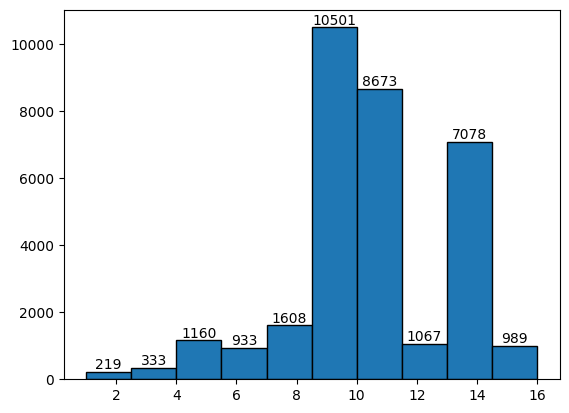

In [15]:
edu_num = adult['Education-Num']
better_hist(edu_num)
plt.show()

In [16]:
def eps_diff_privacy_hist(data: pd.DataFrame, eps: float) -> pd.Series:
  sensitivity = 1
  noise = np.random.laplace(0, sensitivity / eps, len(data))
  noisy_data = data + noise
  noisy_data = np.maximum(noisy_data, 0)
  return noisy_data

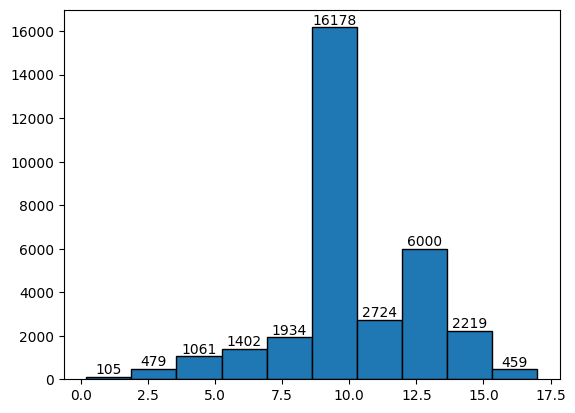

In [17]:
private_data = eps_diff_privacy_hist(edu_num, 5)
better_hist(private_data)

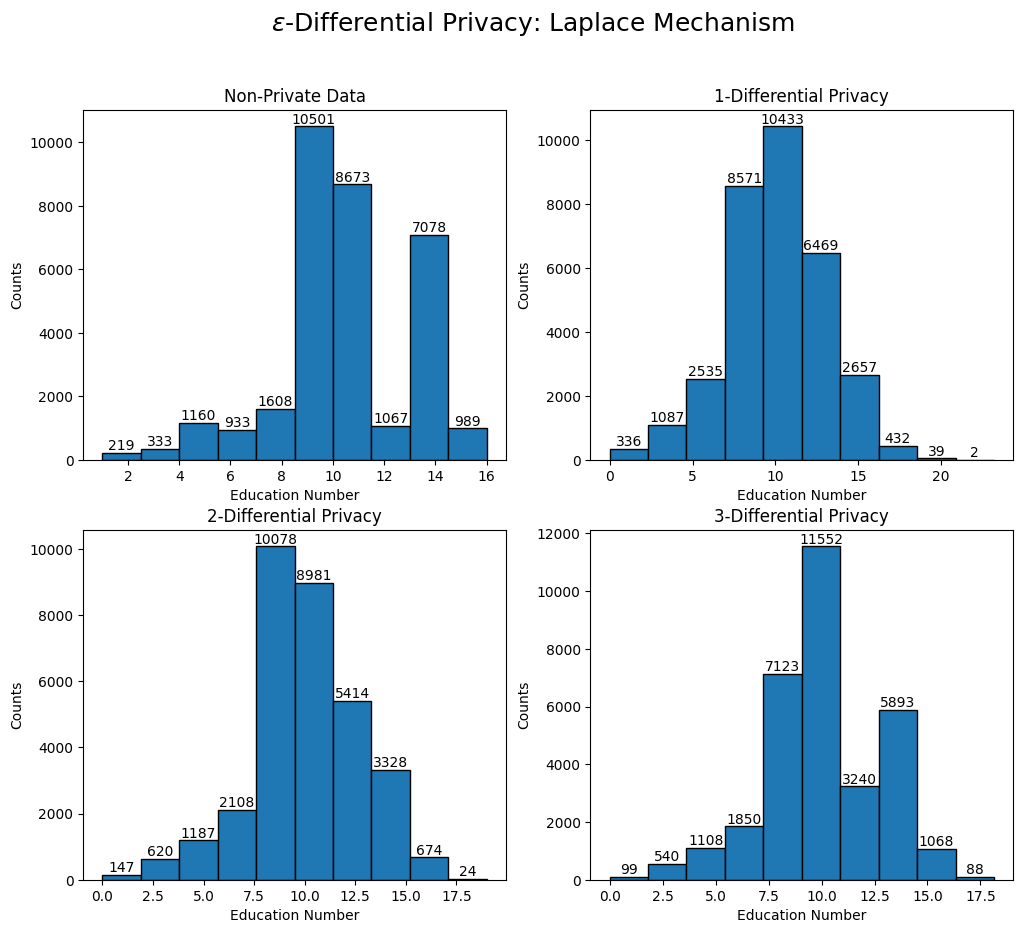

In [18]:
eps = [0, 1, 2, 3]

plt.figure(figsize = (12, 10))
for i, ep in enumerate(eps):
  plt.subplot(2, 2, i + 1)

  if i == 0:
    better_hist(edu_num)
    plt.title('Non-Private Data')
  else:
    private_data = eps_diff_privacy_hist(edu_num, ep)
    better_hist(private_data)
    plt.title(f'{ep}-Differential Privacy')

  plt.xlabel('Education Number')
  plt.ylabel('Counts')

plt.suptitle(r'$\varepsilon$-Differential Privacy: Laplace Mechanism', fontsize = '18')
plt.show()